In [1]:
# !pip install palmerpenguins
from palmerpenguins import load_penguins
penguins = load_penguins()

missing_data = penguins.isnull().any(axis=1)
penguins = penguins.loc[~missing_data]
print(penguins.shape)
penguins.describe()

(333, 8)


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,333.000000,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057,2008.042042
std,5.468668,1.969235,14.015765,805.215802,0.812944
min,32.100000,13.100000,172.000000,2700.000000,2007.000000
25%,39.500000,15.600000,190.000000,3550.000000,2007.000000
50%,44.500000,17.300000,197.000000,4050.000000,2008.000000
75%,48.600000,18.700000,213.000000,4775.000000,2009.000000
max,59.600000,21.500000,231.000000,6300.000000,2009.000000


In [79]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


разбор главы

In [2]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [32]:
adelie_mask = (penguins["species"] == "Adelie")
adelie_mass_obs = penguins.loc[adelie_mask, "body_mass_g"].values
with pm.Model() as model_adelie_penguin_mass:
    σ = pm.HalfStudentT("σ", 100, 2000)
    μ = pm.Normal("μ", 4000, 3000)
    mass = pm.Normal("mass", mu=μ, sigma=σ, observed=adelie_mass_obs)

    prior = pm.sample_prior_predictive(samples=5000)
    trace = pm.sample(chains=10)
    # inf_data_adelie_penguin_mass = az.from_pymc3(prior=prior, trace=trace)

Sampling: [mass, μ, σ]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 2 seconds.


array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

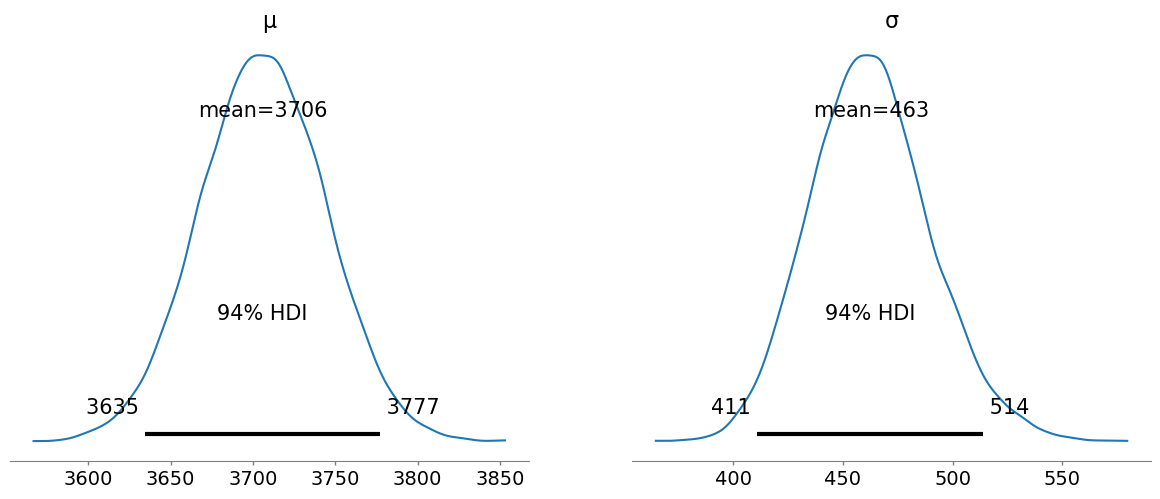

In [34]:
az.plot_posterior(trace)

In [ ]:
with model_adelie_penguin_mass:
    pm.set_data()

array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

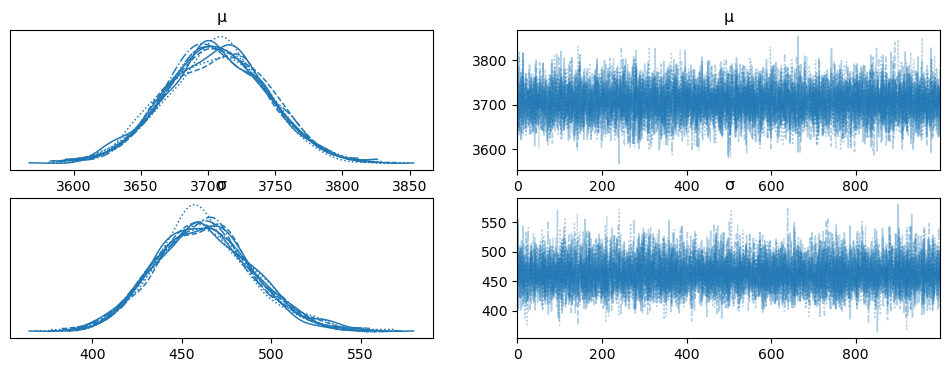

In [37]:
az.plot_trace(trace)

In [57]:
# используем данные о длинах крыльев
adeline_flipper_length_obs = penguins.loc[adelie_mask, 'flipper_length_mm']

with pm.Model() as flipper_length_model:
    adeline_flipper_length = pm.Data('flipper_lengts', adeline_flipper_length_obs, mutable= True)
    sigma = pm.HalfStudentT('sigma', 200, 3000)
    beta_1 = pm.Normal('beta_1', 0, 4000)
    beta_2 = pm.Normal('beta_2', 0, 4000)
    mu = pm.Deterministic("mu", beta_1 + beta_2 * adeline_flipper_length)
    mass = pm.Normal("mass", mu, sigma, observed=adelie_mass_obs)

    trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_1, beta_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [62]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

array([<Axes: title={'center': 'beta_1'}>,
       <Axes: title={'center': 'beta_2'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

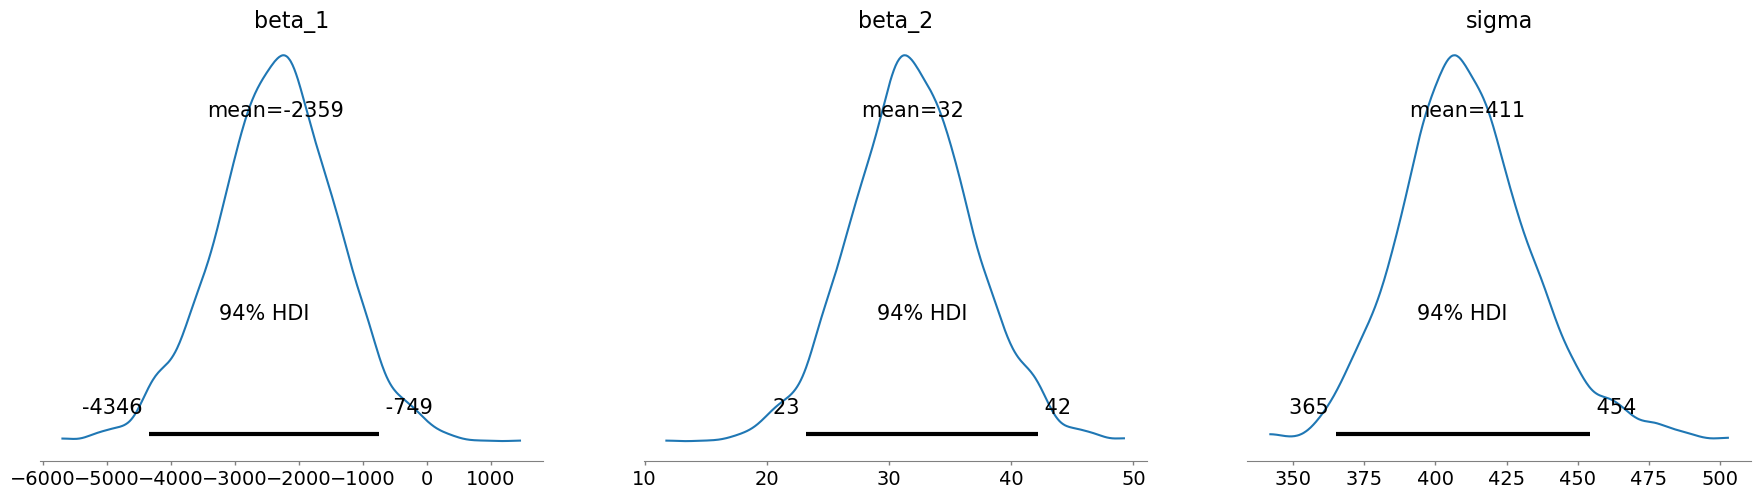

In [74]:
az.plot_posterior(trace, var_names=['beta_1', 'beta_2', 'sigma'])

In [76]:
with flipper_length_model:
    pm.set_data({'flipper_lengts': [200]})
    posterior_predictions = pm.sample_posterior_predictive(\
        trace.posterior, var_names = ['mass', 'mu'])

Sampling: [mass]


<Axes: >

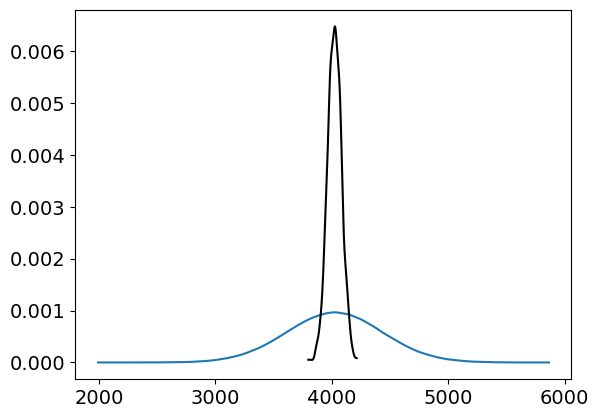

In [78]:
az.plot_dist(posterior_predictions.posterior_predictive.mass)
az.plot_dist(posterior_predictions.posterior_predictive.mu, color = 'black')

In [81]:
species_filter = penguins["species"].isin(["Adelie", "Chinstrap"])
bill_length_obs = penguins.loc[species_filter, "bill_length_mm"].values
species = pd.Categorical(penguins.loc[species_filter, "species"])

with pm.Model() as model_logistic_penguins_bill_length:
    β_0 = pm.Normal("β_0", mu=0, sigma=10)
    β_1 = pm.Normal("β_1", mu=0, sigma=10)

    μ = β_0 + pm.math.dot(bill_length_obs, β_1)

    # Application of our sigmoid  link function
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))

    # Useful for plotting the decision boundary later
    bd = pm.Deterministic("bd", -β_0/β_1)

    # Note the change in likelihood
    yl = pm.Bernoulli("yl", p=θ, observed=species.codes)

    prior_predictive_logistic_penguins_bill_length = pm.sample_prior_predictive()
    trace_logistic_penguins_bill_length = pm.sample(5000, chains=4)
    # inf_data_logistic_penguins_bill_length = az.from_pymc3(
    #     prior=prior_predictive_logistic_penguins_bill_length,
    #     trace=trace_logistic_penguins_bill_length)

Sampling: [yl, β_0, β_1]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_0, β_1]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 7 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


/Users/ilgam/miniconda3/envs/ml/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (217) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'β_0'}>, <Axes: title={'center': 'β_1'}>,
        <Axes: title={'center': 'θ\n0'}>,
        <Axes: title={'center': 'θ\n1'}>],
       [<Axes: title={'center': 'θ\n2'}>,
        <Axes: title={'center': 'θ\n3'}>,
        <Axes: title={'center': 'θ\n4'}>,
        <Axes: title={'center': 'θ\n5'}>],
       [<Axes: title={'center': 'θ\n6'}>,
        <Axes: title={'center': 'θ\n7'}>,
        <Axes: title={'center': 'θ\n8'}>,
        <Axes: title={'center': 'θ\n9'}>],
       [<Axes: title={'center': 'θ\n10'}>,
        <Axes: title={'center': 'θ\n11'}>,
        <Axes: title={'center': 'θ\n12'}>,
        <Axes: title={'center': 'θ\n13'}>],
       [<Axes: title={'center': 'θ\n14'}>,
        <Axes: title={'center': 'θ\n15'}>,
        <Axes: title={'center': 'θ\n16'}>,
        <Axes: title={'center': 'θ\n17'}>],
       [<Axes: title={'center': 'θ\n18'}>,
        <Axes: title={'center': 'θ\n19'}>,
        <Axes: title={'center': 'θ\n20'}>,
        <Axes: title={'cente

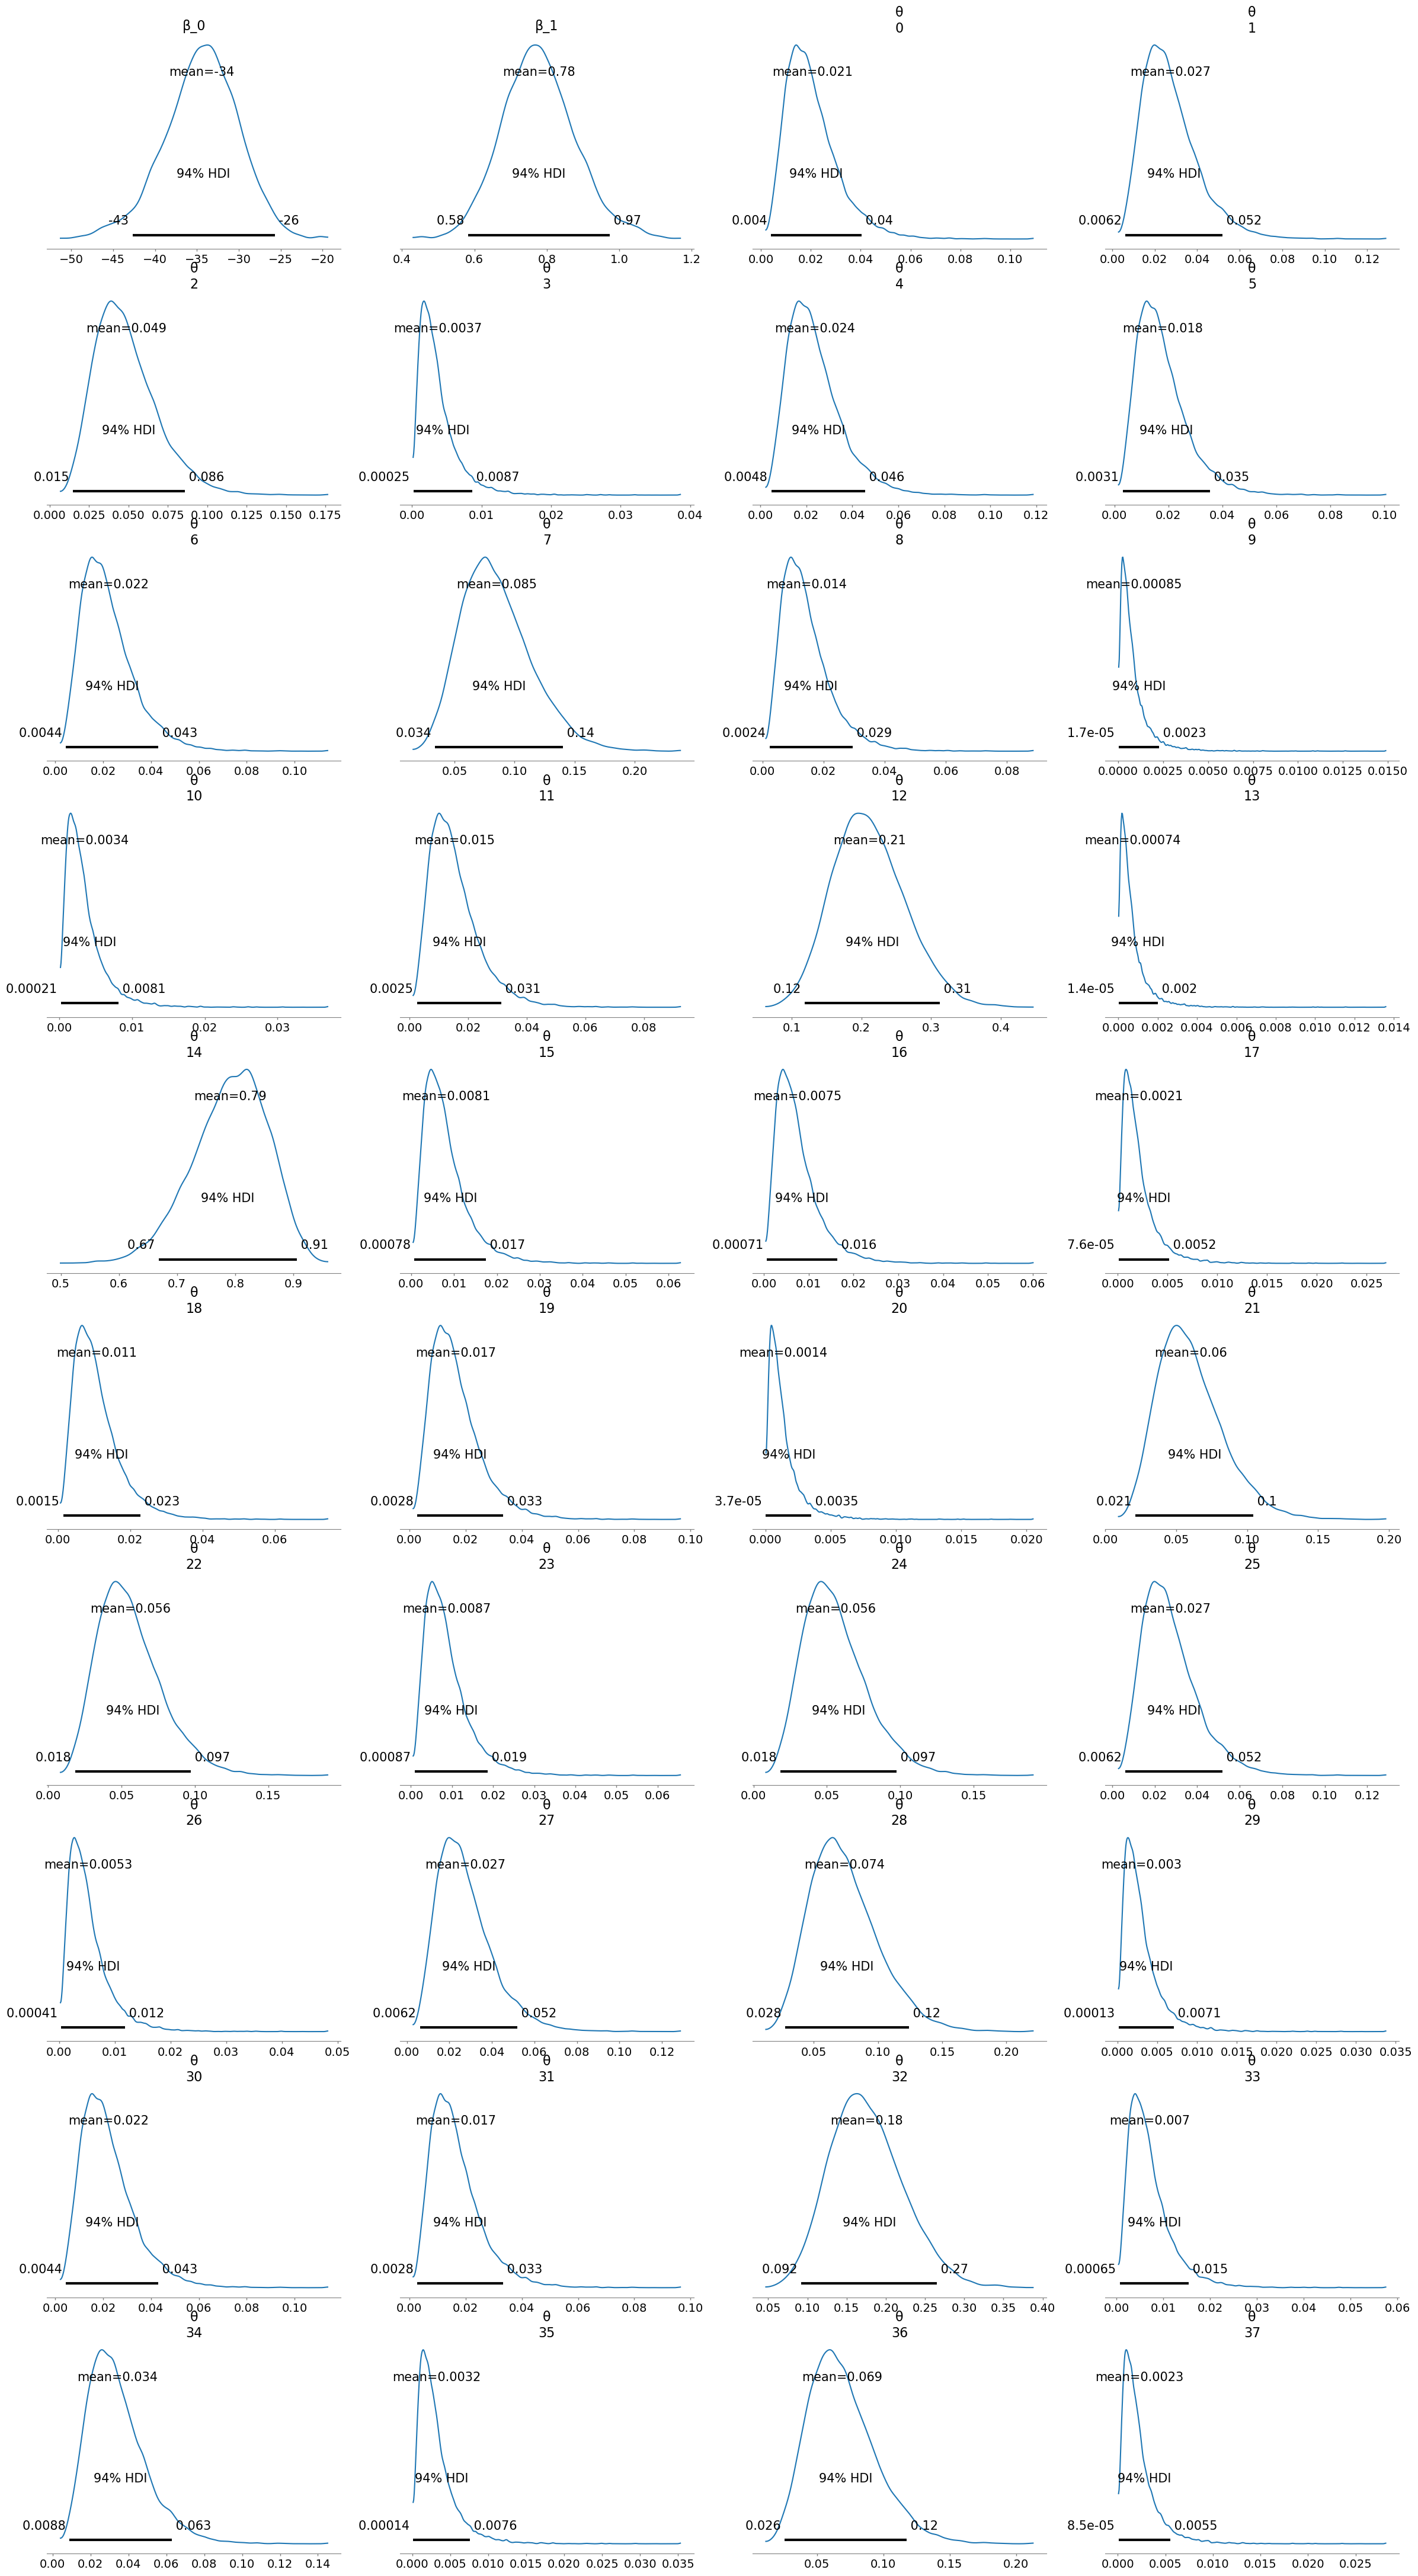

In [82]:
az.plot_posterior(trace_logistic_penguins_bill_length)

# PyMC

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [23]:
rng.standard_normal(100) + 1

array([ 1.45679335,  0.6421258 ,  1.84069994,  0.9491616 ,  1.29213688,
        1.31563007,  0.98701189, -0.08563365,  0.61257893,  0.9203638 ,
        0.93752137,  3.7269218 ,  0.28651349,  0.49653818,  1.98088342,
        0.6850153 ,  2.1165858 , -0.58843384,  1.14319632,  0.42740177,
        0.07671279,  2.0649091 ,  0.07368749,  1.50958623, -0.24856497,
        1.71405325,  1.07162526, -0.33597726, -0.39114059,  0.92551798,
        1.17775829,  1.39116772,  3.32734576,  2.36393171,  1.90771231,
       -0.35902856,  1.70002363,  1.38400209,  3.72304322,  2.32736702,
        1.69797477,  1.78547711,  0.21850519,  2.11591286,  0.3365242 ,
        1.53491819,  0.63462675,  1.26609353,  0.1838732 ,  0.73564204,
        1.19172789, -0.13250115,  3.22183858,  0.03696819,  2.27240529,
        1.3797309 ,  1.32228824,  1.58021649,  0.83269431,  1.74066925,
        0.32684609,  0.54698728,  0.29910178,  2.668035  ,  1.34614484,
        0.98582159,  0.53112968,  1.294816  ,  0.45340546, -0.34

In [35]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu =-1, sigma = 1)
    obs = pm.Normal('obs', mu = mu, sigma = 1, observed= + 1)
    

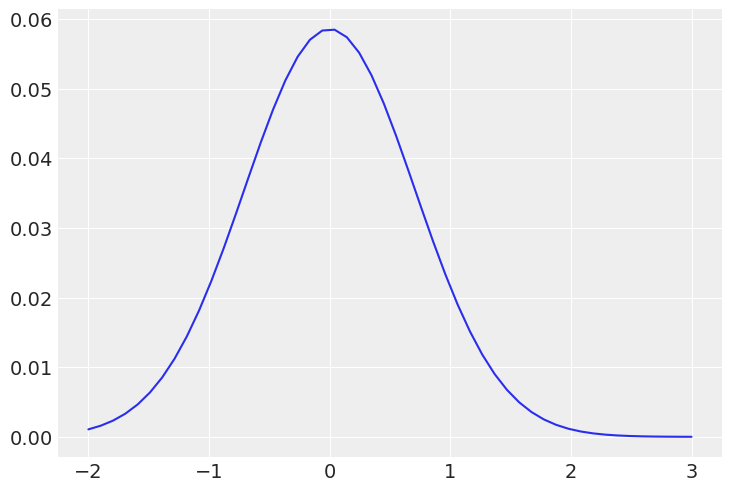

In [43]:
logp = model.compile_logp()

x = np.linspace(-2, 3, 50)
y = [logp({'mu': x_}) for x_ in x]
plt.plot(x, np.exp(y))

In [51]:
sigma = np.random.rand(5,5)
with pm.Model(coords = {'idx': np.arange(5)}) as model:
    x = pm.Normal('x', mu = np.arange(5), sigma = sigma, dims = 'idx')

model.initial_point()

ValueError: Size length is incompatible with batched dimensions of parameter 1 [[0.374552 ... 94231212]]:
len(size) = 1, len(batched dims [[0.374552 ... 94231212]]) = 2. Size length must be 0 or >= 2

INFERENCE

In [11]:
np.random.rand(100).shape

(100,)

In [15]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu = 0, sigma = 1)
    sigma = pm.HalfStudentT('sigma', nu = 1, sigma = 10 )
    obs = pm.Normal('obs', mu = mu, sigma = sigma, observed= \
                    np.random.rand(100))
    idata = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


In [16]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [62]:
idata.posterior['mu']

<xarray.DataArray 'mu' (chain: 4, draw: 2000)>
array([[ 0.10254755,  0.10254755,  0.09902921, ...,  0.02753473,
         0.02753473, -0.069365  ],
       [ 0.12364885,  0.12364885,  0.12943794, ...,  0.16262641,
         0.05874437, -0.01007112],
       [ 0.07129194, -0.0621424 , -0.0621424 , ..., -0.04893427,
         0.01567443, -0.03186708],
       [-0.01427061,  0.02977127, -0.0330272 , ...,  0.08106713,
         0.02654969,  0.03938754]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

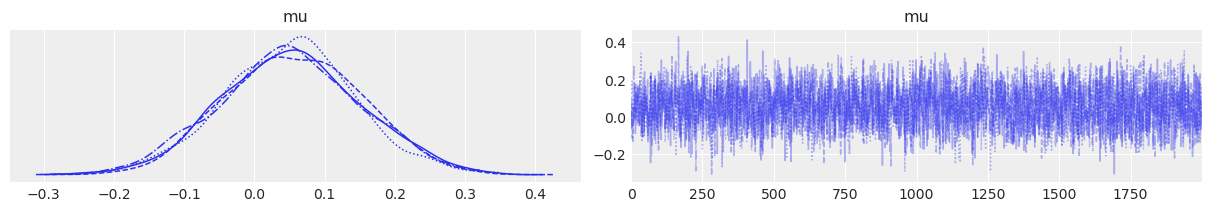

In [63]:
az.plot_trace(idata)

In [97]:
dims = 5
m = 1000

def logistic(w, x):
    return 1/(1 + np.exp(-x[:, :-1]@ w[:-1]))

w = np.random.randn(dims)
X = np.random.randn(m, dims)
y_obs = np.random.binomial(1, logistic(w, X) )
with pm.Model(coords = {'idx': range(dims)}) as model:
    w_ = pm.Normal('w', mu = 0, sigma = 2, dims = 'idx')
    p_s = logistic(w_, X)
    y = pm.Bernoulli('y', p = p_s, observed = y_obs)
    idata = pm.sample(cores = 4, chains= 6)

    approx = pm.fit()
    idata_variational = approx.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [w]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 2 seconds.


Finished [100%]: Average Loss = 374.12


array([ 0.88132041, -1.65729763, -1.50197778,  1.12040012,  0.25136129])

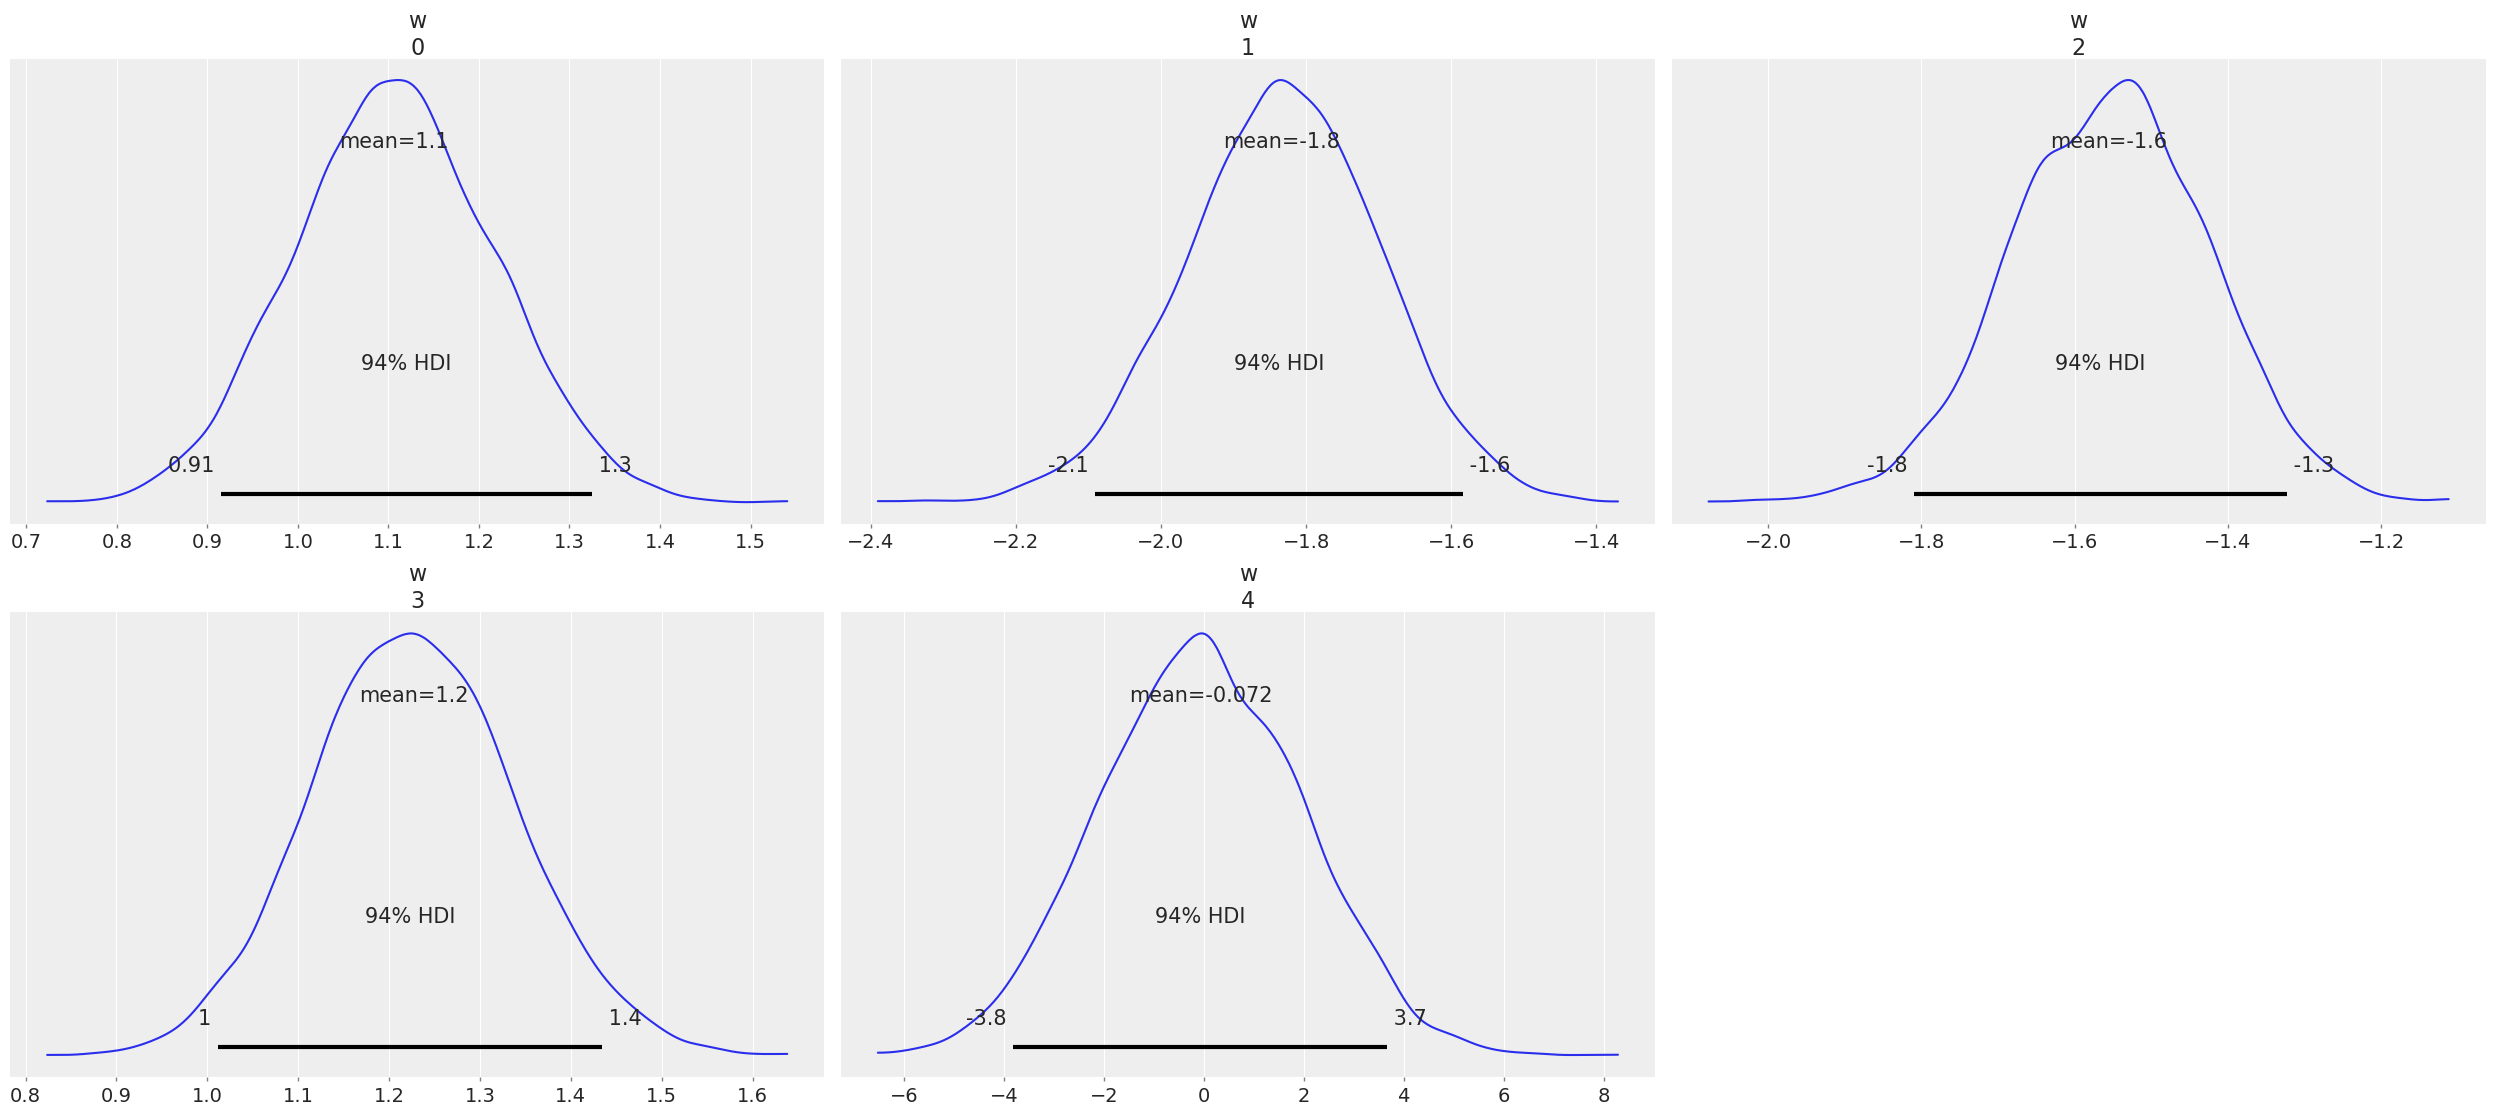

In [98]:
az.plot_posterior(idata)
w

array([ 0.88132041, -1.65729763, -1.50197778,  1.12040012,  0.25136129])

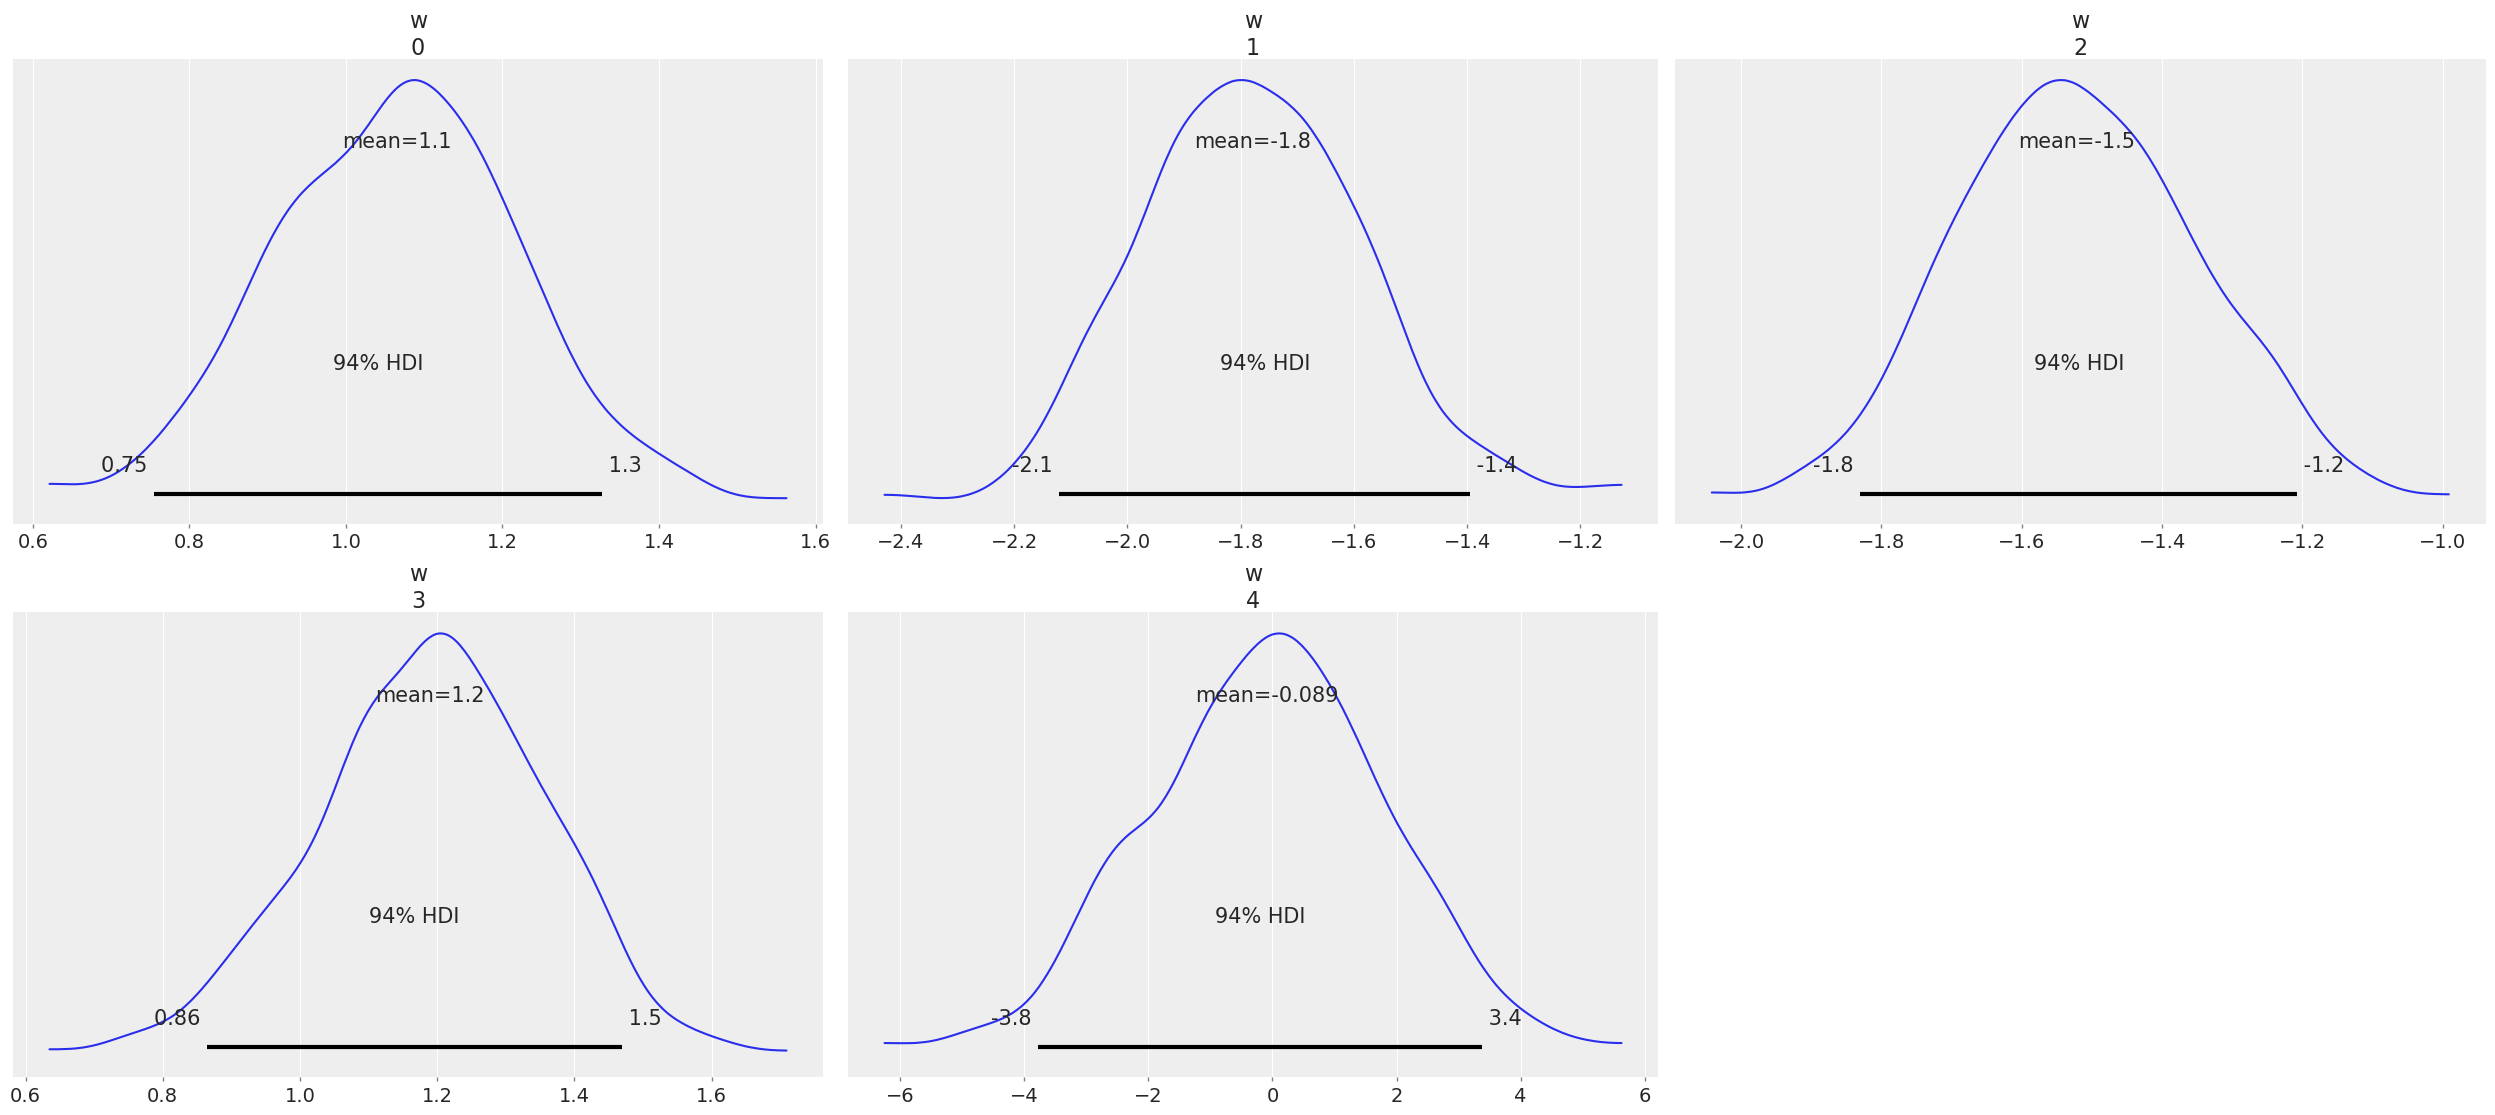

In [99]:
az.plot_posterior(idata_variational)
w

In [96]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.981,0.275,0.474,1.507,0.003,0.002,7387.0,5382.0,1.0
w[1],0.663,0.261,0.179,1.161,0.003,0.002,7231.0,5245.0,1.0
w[2],0.676,0.281,0.175,1.223,0.004,0.003,6170.0,4658.0,1.0
w[3],-0.093,0.243,-0.568,0.356,0.003,0.003,5722.0,4076.0,1.0
w[4],0.026,1.992,-3.636,3.873,0.023,0.024,7238.0,4822.0,1.0


In [100]:
x = rng.standard_normal(100)
y = x > 0

coords = {"idx": np.arange(100)}
with pm.Model() as model:
    # create shared variables that can be changed later on
    x_obs = pm.MutableData("x_obs", x, dims="idx")
    y_obs = pm.MutableData("y_obs", y, dims="idx")

    coeff = pm.Normal("x", mu=0, sigma=1)
    logistic = pm.math.sigmoid(coeff * x_obs)
    pm.Bernoulli("obs", p=logistic, observed=y_obs, dims="idx")
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


In [101]:
with model:
    # change the value and shape of the data
    pm.set_data(
        {
            "x_obs": [-1, 0, 1.0],
            # use dummy values with the same shape:
            "y_obs": [0, 0, 0],
        },
        coords={"idx": [1001, 1002, 1003]},
    )

    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [obs]


In [104]:
idata.posterior_predictive["obs"].mean(dim=["draw", "chain"])

<xarray.DataArray 'obs' (idx: 3)>
array([0.02775, 0.49075, 0.977  ])
Coordinates:
  * idx      (idx) int64 1001 1002 1003